## Titanic (train) - Machine Learning from Disaster

In [1]:
from utils import *

In [2]:
data = pd.read_csv('dataset/train.csv')
test = pd.read_csv('dataset/test.csv')
gender_submission = pd.read_csv('dataset/gender_submission.csv')

### Explore the Train Data

Problem Statement: It is to build a predictive model that identifies key factors associated with survival on the Titanic. I aim to explore how variables such as age, gender, class, fare, and family connections influence the likelihood of survival. It will not only predict survival outcomes but also understand the demographic and socio-economic characteristics that were most likely to increase survival chances.

In [3]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
print(data.shape)
print(test.shape)

(891, 12)
(418, 11)


### Data Preprocessing

In [5]:
data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
data.duplicated().sum()

0

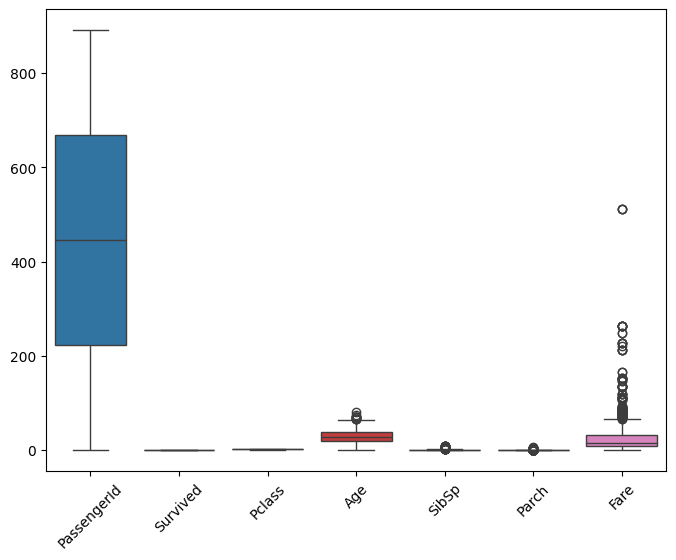

In [7]:
plt.figure(figsize=(8,6))
sns.boxplot(data=data)
plt.xticks(rotation=45)
plt.show()

In [8]:
numerical_cols = data.select_dtypes(include=['number']).columns
for col in numerical_cols:
    outliers = detect_outliers_iqr(data, col)
    print(f"Outliers in {col}: {len(outliers)}")

Outliers in PassengerId: 2
Outliers in Survived: 2
Outliers in Pclass: 2
Outliers in Age: 2
Outliers in SibSp: 2
Outliers in Parch: 2
Outliers in Fare: 2


In [9]:
data = preprocess_data(data, is_train=True)
print(data.isnull().sum())
data.head()


Survived      0
Pclass        0
Sex           0
Age           0
Fare          0
Embarked      0
TicketCode    0
FamilySize    0
IsAlone       0
dtype: int64


,Survived,Pclass,Sex,Age,Fare,Embarked,TicketCode,FamilySize,IsAlone
0,0,3,male,22.0,7.2500,S,5,2,0
1,1,1,female,38.0,71.2833,C,17599,2,0
2,1,3,female,26.0,7.9250,S,2,1,1
3,1,1,female,35.0,53.1000,S,113803,2,0
4,0,3,male,35.0,8.0500,S,373450,1,1


In [10]:
test.shape

(418, 11)

In [11]:
data = data.drop_duplicates()
data.duplicated().sum()

0

In [12]:
data.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'TicketCode',
       'FamilySize', 'IsAlone'],
      dtype='object')

In [13]:
data = data.drop('TicketCode', axis=1)

Observation: 
- Missing values from age are filled in with the median age within each Pclass as there are outliers. Imputing Age by Pclass is more nuanced approach compared to using a global median imputation. Fractional age is kept in case it affected to survival of parents.

- Since there are high number, 687 of 891, NaNs in Cabin, and a lot of values are mixed and inconsistent, Cabin column is dropped.

- Name and Ticket columns are dropped as they are not meaningful patterns fo survival.

- for 'Embarked', the most common value can be a reasonable guess for two missing values.

- PassengerId is removed for now as it's not necessary for modeling.


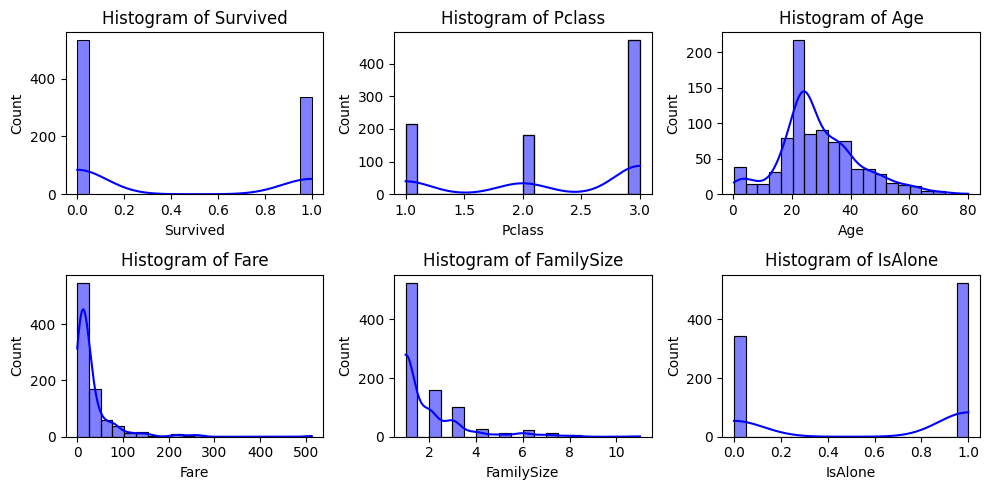

In [14]:
numerical_columns = data.select_dtypes(include=['number']).columns

plt.figure(figsize=(10,5))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(2, 3, i)
    sns.histplot(data[col], kde=True, bins=20, color='blue')
    plt.title(f'Histogram of {col}')
    plt.tight_layout()
plt.show()

Observation: In titanic, it seems the majority of passengers being in their 20s. Younger passengers could have had different survival chances compared to older adults. This could be useful to anlyze by looking at the survival rates for different age groups.

Most passengers had no siblings, spouse, parents, or children. If family members were prioritized for lifeboat access or rescue, the survival rate could have been different. It coulld analyze how the rate differ for solo travelers versus families.

A lot of passengers paid less than $100 and there were much more people in 3rd/lower pclass. Lower fares generally correspond to lower class tickets.

### Exploratory Data Analysis (EDA)

In [15]:
data.describe()

,Survived,Pclass,Age,Fare,FamilySize,IsAlone
count,869.000000,869.000000,869.000000,869.000000,869.000000,869.000000
mean,0.385501,2.295742,29.197261,32.213305,1.851554,0.605293
std,0.486994,0.838994,13.353909,50.134850,1.466150,0.489069
min,0.000000,1.000000,0.420000,0.000000,1.000000,0.000000
25%,0.000000,2.000000,22.000000,7.895800,1.000000,0.000000
50%,0.000000,3.000000,26.000000,14.454200,1.000000,1.000000
75%,1.000000,3.000000,37.000000,30.695800,2.000000,1.000000
max,1.000000,3.000000,80.000000,512.329200,11.000000,1.000000


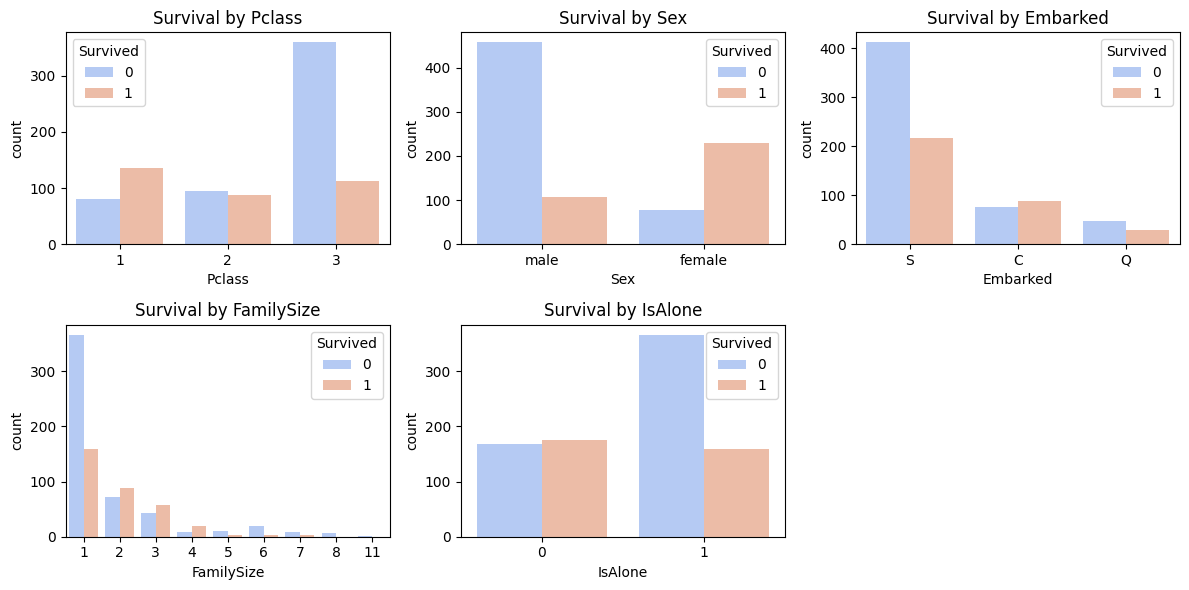

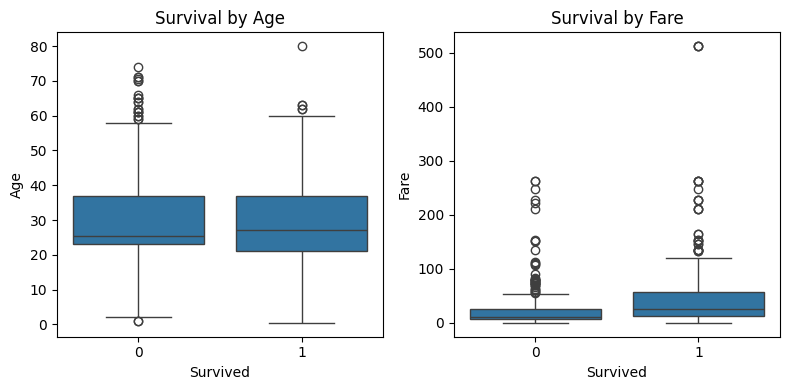

In [16]:
# List of categorical columns
categorical_columns = ['Pclass', 'Sex', 'Embarked', 'FamilySize', 'IsAlone']

# Count plots for categorical features
plt.figure(figsize=(12, 6))
for i, column in enumerate(categorical_columns, 1):
    plt.subplot(2, 3, i)
    sns.countplot(x=column, hue='Survived', data=data, palette='coolwarm')
    plt.title(f'Survival by {column}')
    plt.tight_layout()
plt.show()

# Box plots for numerical features like 'Age' and 'Fare'
plt.figure(figsize=(8, 4))

# Age distribution by Survived
plt.subplot(1, 2, 1)
sns.boxplot(x='Survived', y='Age', data=data)
plt.title('Survival by Age')

# Fare distribution by Survived
plt.subplot(1, 2, 2)
sns.boxplot(x='Survived', y='Fare', data=data)
plt.title('Survival by Fare')

plt.tight_layout()
plt.show()


In [17]:
features = ['Sex', 'Pclass', 'IsAlone']

for feature in features:
    print(f"\nSurvival Rate by {feature}:")
    print(data.groupby(feature)['Survived'].mean().apply(lambda x: f"{x:.2%}"))


Survival Rate by Sex:
Sex
female    74.84%
male      18.83%
Name: Survived, dtype: object

Survival Rate by Pclass:
Pclass
1    62.79%
2    47.80%
3    23.94%
Name: Survived, dtype: object

Survival Rate by IsAlone:
IsAlone
0    51.02%
1    30.42%
Name: Survived, dtype: object


Observation:

- Pclass: Passengers in 1 class had the highest survival rate, while those in class 3 had the lowest survival rate, meaning highest number of deaths.

- Sex: Female passengers had a significantly higher survival rate than male passengers. This supports the well-known 'women and children first' narrative during the Titanic evacuation.

- Embarked: Most passengers embarked from Southampton, showing both survival and non-survival counts are higher.

- FamilySize, IsAlone: Passengers traveling alone had the lowest survival rate, at the same time, highest survival rate compared to those who have more than one famillysize. Large families also show lower survival rates.

- Age: Most of the older adults (over 60) had a very low survival rate.

- Fare: Passengers who paid higher fares were more likely to survive.


In [18]:
data = encode_feature(data)

data.head()

,Survived,Pclass,Sex,Age,Fare,FamilySize,IsAlone,Embarked_Q,Embarked_S
0,0,3,0,22.0,7.2500,2,0,0,1
1,1,1,1,38.0,71.2833,2,0,0,0
2,1,3,1,26.0,7.9250,1,1,0,1
3,1,1,1,35.0,53.1000,2,0,0,1
4,0,3,0,35.0,8.0500,1,1,0,1


In [19]:
corr = data.select_dtypes(include=['number']).corr()
corr

,Survived,Pclass,Sex,Age,Fare,FamilySize,IsAlone,Embarked_Q,Embarked_S
Survived,1.000000,-0.341388,0.549641,-0.046797,0.259767,0.044743,-0.206900,-0.002494,-0.134739
Pclass,-0.341388,1.000000,-0.133599,-0.406784,-0.556100,0.040414,0.147235,0.226007,0.070530
Sex,0.549641,-0.133599,1.000000,-0.075478,0.182378,0.209512,-0.296828,0.070258,-0.110407
Age,-0.046797,-0.406784,-0.075478,1.000000,0.124527,-0.263844,0.162332,-0.084083,0.012665
Fare,0.259767,-0.556100,0.182378,0.124527,1.000000,0.216037,-0.270942,-0.117184,-0.165487
FamilySize,0.044743,0.040414,0.209512,-0.263844,0.216037,1.000000,-0.719663,-0.054814,0.070914
IsAlone,-0.206900,0.147235,-0.296828,0.162332,-0.270942,-0.719663,1.000000,0.091651,0.022486
Embarked_Q,-0.002494,0.226007,0.070258,-0.084083,-0.117184,-0.054814,0.091651,1.000000,-0.501176
Embarked_S,-0.134739,0.070530,-0.110407,0.012665,-0.165487,0.070914,0.022486,-0.501176,1.000000


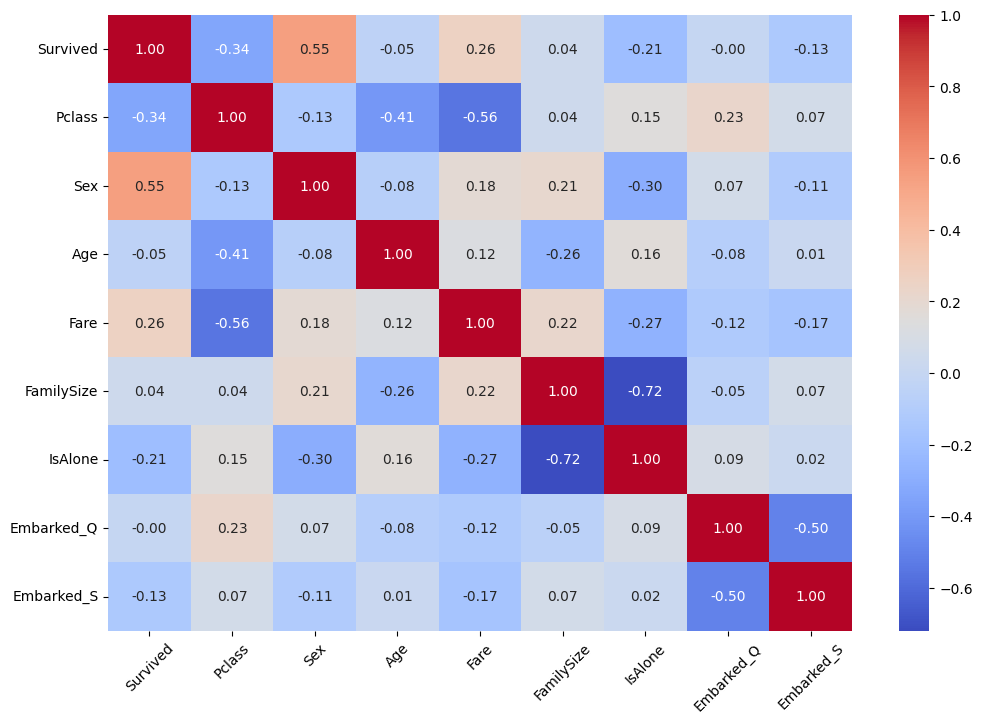

In [20]:
plt.figure(figsize=(12,8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.xticks(rotation=45)
plt.show()

In [21]:
survived_corr = corr['Survived'].sort_values(ascending=False)
survived_corr[1:]

Sex           0.549641
Fare          0.259767
FamilySize    0.044743
Embarked_Q   -0.002494
Age          -0.046797
Embarked_S   -0.134739
IsAlone      -0.206900
Pclass       -0.341388
Name: Survived, dtype: float64

Observation:
- Sex: 0.549 correlation
    
    Strongest predictor. Female significantly increased survival chances.
- Pclass: -0.34 correlation
    
    Pclass 3 was associated with lower survival.
- IsAlone: -0.206 correlation
    
    Being alone reduced survival chances.
- Fare: 0.259 correlation
    
    Higher fare generally meant higher survival probability.

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'Survived'),
  Text(1, 0, 'Pclass'),
  Text(2, 0, 'Sex'),
  Text(3, 0, 'Age'),
  Text(4, 0, 'Fare'),
  Text(5, 0, 'FamilySize'),
  Text(6, 0, 'IsAlone'),
  Text(7, 0, 'Embarked_Q'),
  Text(8, 0, 'Embarked_S')])

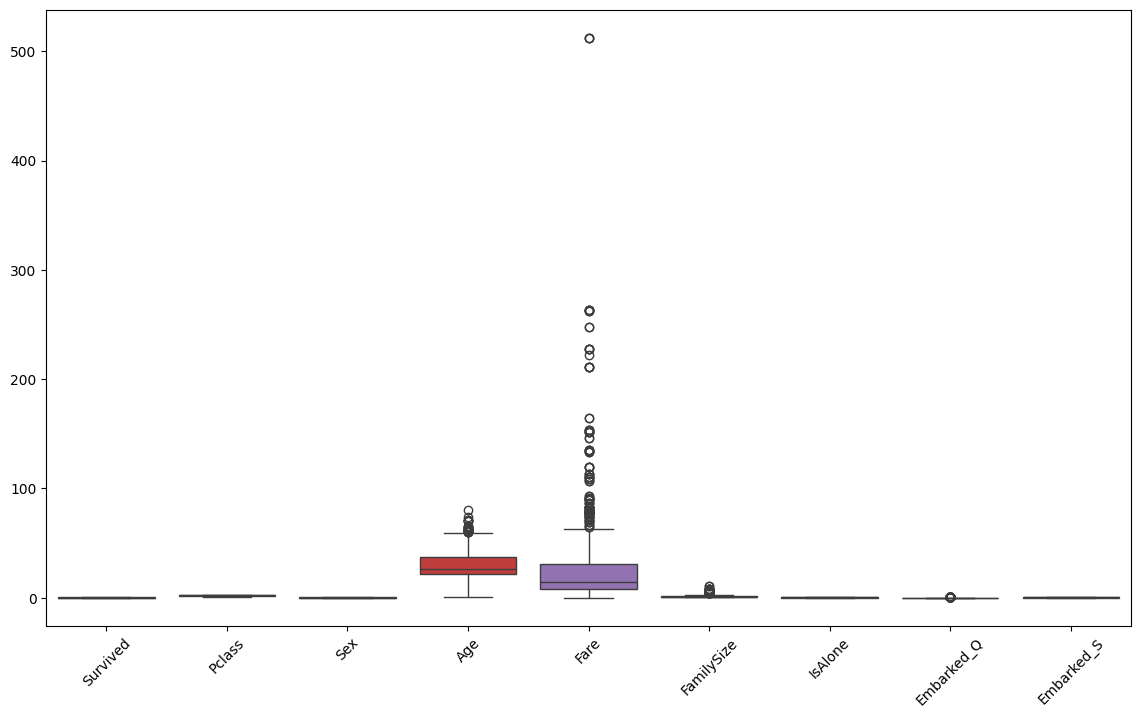

In [22]:
plt.figure(figsize=(14, 8))
sns.boxplot(data=data)
plt.xticks(rotation=45)

Observation: Since there are outliers, using RobustScaler is a better choice.

### Model Training

In [23]:
X_train_scaled, X_test_scaled, Y_train, Y_test = splitting_data(data, return_all=True)

Size of training data: 695
Size of test data: 174


In [24]:
data['Survived'].value_counts()

Survived
0    534
1    335
Name: count, dtype: int64

### Logistic Regression

In [25]:
lr = LogisticRegression(random_state=42, max_iter=200)
evaluate_model(lr, X_train_scaled, X_test_scaled, Y_train, Y_test)

Train Accuracy: 0.81
Test Accuracy: 0.82

Confusion Matrix (Train):
 [[373  56]
 [ 79 187]]

Confusion Matrix (Test):
 [[84 21]
 [11 58]]

Classification Report (Train):
              precision    recall  f1-score   support

Not Survived       0.83      0.87      0.85       429
    Survived       0.77      0.70      0.73       266

    accuracy                           0.81       695
   macro avg       0.80      0.79      0.79       695
weighted avg       0.80      0.81      0.80       695


Classification Report (Test):
              precision    recall  f1-score   support

Not Survived       0.88      0.80      0.84       105
    Survived       0.73      0.84      0.78        69

    accuracy                           0.82       174
   macro avg       0.81      0.82      0.81       174
weighted avg       0.82      0.82      0.82       174



LogisticRegression(max_iter=200, random_state=42)

Overall Performance:
- Accuracy: The model is generalizing well. No major overfitting is happening.

- Confusion Matrix (Test): The model predicts 'Not Survived' a bit better than 'Survived'.

- Classification Report (Test)
    - Precision for Survived (0.73): 73% of the time the model says someone survived.
    - Recall for Survived (0.84): The model only catches 84% of acutal survivors. It might be missing survivors.
    - F1-Score for Survived (0.78): Balanced view of precision and recall.

### KNN

In [26]:
knn = KNeighborsClassifier()
evaluate_model(knn, X_train_scaled, X_test_scaled, Y_train, Y_test)

Train Accuracy: 0.86
Test Accuracy: 0.75

Confusion Matrix (Train):
 [[386  43]
 [ 57 209]]

Confusion Matrix (Test):
 [[83 22]
 [21 48]]

Classification Report (Train):
              precision    recall  f1-score   support

Not Survived       0.87      0.90      0.89       429
    Survived       0.83      0.79      0.81       266

    accuracy                           0.86       695
   macro avg       0.85      0.84      0.85       695
weighted avg       0.86      0.86      0.86       695


Classification Report (Test):
              precision    recall  f1-score   support

Not Survived       0.80      0.79      0.79       105
    Survived       0.69      0.70      0.69        69

    accuracy                           0.75       174
   macro avg       0.74      0.74      0.74       174
weighted avg       0.75      0.75      0.75       174



KNeighborsClassifier()

Overall Performance:
- Accuracy: The model achieves 86% accuracy on the training set, indicating a relatively good fit to the training data. However, there's a gap between train and test performance, suggesting potential overfitting.

- Classification Report (Test): Precision for 'Survived' is 0.69, with recall of 0.70, indicating that the model is not performing as well for the "Survived" class on the test set. This suggests that the model has difficulty identifying the survivors, resulting in false negatives.



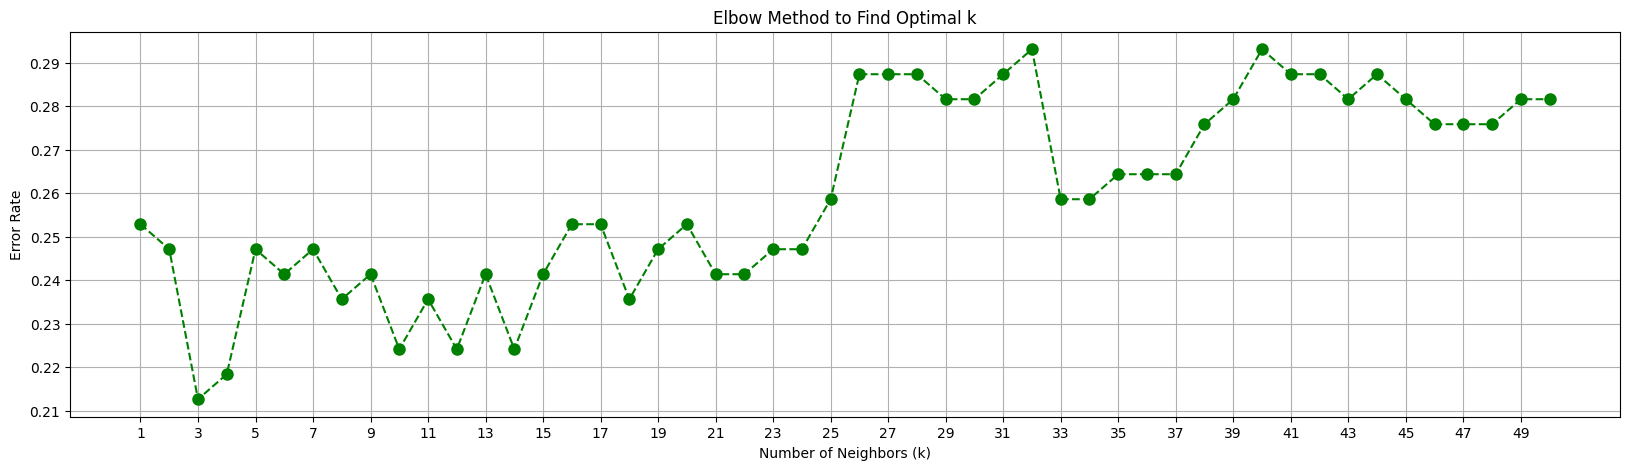

In [27]:
error_rates =[]
k_values = range(1, 51)
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, Y_train)  # train the model
    y_knn_pred = knn.predict(X_test_scaled)  # predict on test set
    error = 1 - accuracy_score(Y_test, y_knn_pred)  # calculate error rate
    error_rates.append(error)

# plot the elbow curve to find the optimal value of k
plt.figure(figsize=(20, 5))
plt.plot(k_values, error_rates, marker='o', linestyle='dashed', markersize=8, color='green')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Error Rate')
plt.title('Elbow Method to Find Optimal k')
plt.xticks(np.arange(1, 51, step=2))
plt.grid(True)
plt.show()

Observation: The error rate significantly decreased when k=3. After that, we don't see any further dip.

In [28]:
knn_3 = KNeighborsClassifier(n_neighbors=3)
evaluate_model(knn_3, X_train_scaled, X_test_scaled, Y_train, Y_test)

Train Accuracy: 0.88
Test Accuracy: 0.79

Confusion Matrix (Train):
 [[394  35]
 [ 46 220]]

Confusion Matrix (Test):
 [[86 19]
 [18 51]]

Classification Report (Train):
              precision    recall  f1-score   support

Not Survived       0.90      0.92      0.91       429
    Survived       0.86      0.83      0.84       266

    accuracy                           0.88       695
   macro avg       0.88      0.87      0.88       695
weighted avg       0.88      0.88      0.88       695


Classification Report (Test):
              precision    recall  f1-score   support

Not Survived       0.83      0.82      0.82       105
    Survived       0.73      0.74      0.73        69

    accuracy                           0.79       174
   macro avg       0.78      0.78      0.78       174
weighted avg       0.79      0.79      0.79       174



KNeighborsClassifier(n_neighbors=3)

Overall Performance:
- Accuracy: The model achieves 88% accuracy on the training set, which is a decent performance but still leaves room for improvement.

- Precision for 'Survived' is 0.86, with recall of 0.83, and an f1-score of 0.84, which is lower than for the 'Not Survived' class. This suggests that the model may be missing some survivors (false negatives), though it still performs decently for this class

### SMOTE on KNN

In [29]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, Y_train_resampled = smote.fit_resample(X_train_scaled, Y_train)

evaluate_model(knn_3, X_train_resampled, X_test_scaled, Y_train_resampled, Y_test)

Train Accuracy: 0.89
Test Accuracy: 0.76

Confusion Matrix (Train):
 [[379  50]
 [ 42 387]]

Confusion Matrix (Test):
 [[81 24]
 [17 52]]

Classification Report (Train):
              precision    recall  f1-score   support

Not Survived       0.90      0.88      0.89       429
    Survived       0.89      0.90      0.89       429

    accuracy                           0.89       858
   macro avg       0.89      0.89      0.89       858
weighted avg       0.89      0.89      0.89       858


Classification Report (Test):
              precision    recall  f1-score   support

Not Survived       0.83      0.77      0.80       105
    Survived       0.68      0.75      0.72        69

    accuracy                           0.76       174
   macro avg       0.76      0.76      0.76       174
weighted avg       0.77      0.76      0.77       174



KNeighborsClassifier(n_neighbors=3)

Overall Performance:
- After applying SMOTE, The model has high performance on the training set, but the overfitting issue is still apparent in the test results.

- False Positives and False Negatives: 24 false positives and 17 false negatives suggest that the model has some difficulty with misclassification on the test set, but these numbers are moderate and could potentially improve with further model refinement.

### Decision Tree

In [30]:
dt = DecisionTreeClassifier(random_state=42)
evaluate_model(dt, X_train_scaled, X_test_scaled, Y_train, Y_test)

Train Accuracy: 0.98
Test Accuracy: 0.76

Confusion Matrix (Train):
 [[428   1]
 [ 11 255]]

Confusion Matrix (Test):
 [[83 22]
 [20 49]]

Classification Report (Train):
              precision    recall  f1-score   support

Not Survived       0.97      1.00      0.99       429
    Survived       1.00      0.96      0.98       266

    accuracy                           0.98       695
   macro avg       0.99      0.98      0.98       695
weighted avg       0.98      0.98      0.98       695


Classification Report (Test):
              precision    recall  f1-score   support

Not Survived       0.81      0.79      0.80       105
    Survived       0.69      0.71      0.70        69

    accuracy                           0.76       174
   macro avg       0.75      0.75      0.75       174
weighted avg       0.76      0.76      0.76       174



DecisionTreeClassifier(random_state=42)

Overall Performance:
- Accuracy: The training accuracy is very high, which indicates that the decision tree model is performing exceptionally well on the training data. However, such a high accuracy also suggests that the model might have overfitted the training data, learning the patterns too well but potentially not generalizing effectively to new, unseen data.

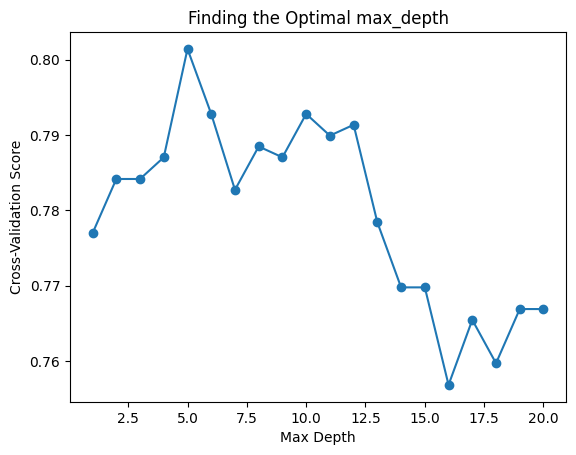

Best max_depth: 5


In [31]:
scores = []
depths = range(1, 21)
for d in depths:
    dt = DecisionTreeClassifier(criterion='entropy', max_depth=d)
    score = cross_val_score(dt, X_train_scaled, Y_train, cv=5).mean()
    scores.append(score)

plt.plot(depths, scores, marker='o')
plt.xlabel("Max Depth")
plt.ylabel("Cross-Validation Score")
plt.title("Finding the Optimal max_depth")
plt.show()

best_depth = depths[np.argmax(scores)]
print(f"Best max_depth: {best_depth}")

In [32]:
dt_5 = DecisionTreeClassifier(random_state=42, criterion='entropy', max_depth=best_depth)
evaluate_model(dt_5, X_train_scaled, X_test_scaled, Y_train, Y_test)

Train Accuracy: 0.85
Test Accuracy: 0.82

Confusion Matrix (Train):
 [[412  17]
 [ 85 181]]

Confusion Matrix (Test):
 [[97  8]
 [24 45]]

Classification Report (Train):
              precision    recall  f1-score   support

Not Survived       0.83      0.96      0.89       429
    Survived       0.91      0.68      0.78       266

    accuracy                           0.85       695
   macro avg       0.87      0.82      0.84       695
weighted avg       0.86      0.85      0.85       695


Classification Report (Test):
              precision    recall  f1-score   support

Not Survived       0.80      0.92      0.86       105
    Survived       0.85      0.65      0.74        69

    accuracy                           0.82       174
   macro avg       0.83      0.79      0.80       174
weighted avg       0.82      0.82      0.81       174



DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42)

Overall Performance:
- Accuracy:The training accuracy is moderate, which indicates that the decision tree is not overfitting as much as in the previous models. A balanced training accuracy suggests that the model generalizes better than some of the other overfitting models observed earlier.

- The test confusion matrix shows that the model performs well, with relatively fewer false positives compared to false negatives, indicating a better balance in predicting both classes.

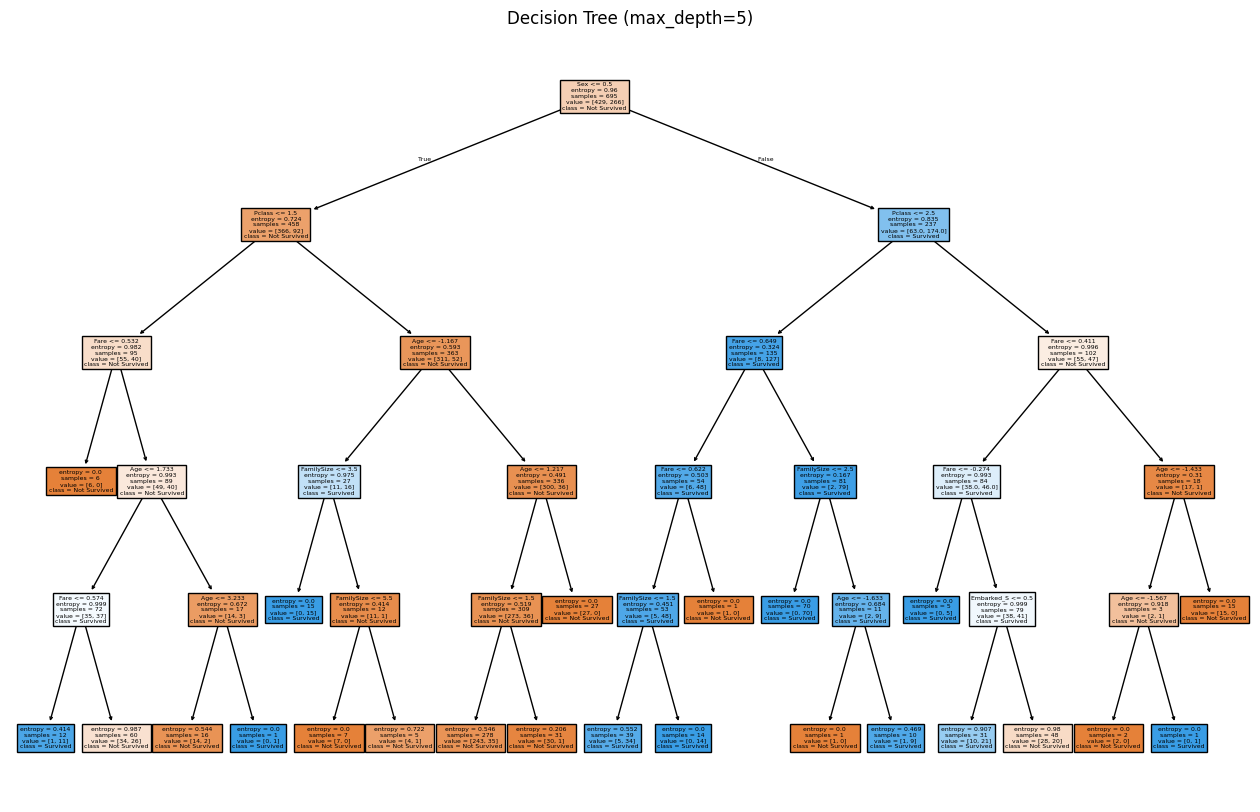

In [33]:
plt.figure(figsize=(16, 10))
plot_tree(dt_5, feature_names=X_train_scaled.columns, class_names=["Not Survived", "Survived"], filled=True)
plt.title("Decision Tree (max_depth=5)")
plt.show()

### Random Forest

In [34]:
rf = RandomForestClassifier( random_state=42)
evaluate_model(rf, X_train_scaled, X_test_scaled, Y_train, Y_test)

Train Accuracy: 0.98
Test Accuracy: 0.81

Confusion Matrix (Train):
 [[426   3]
 [  9 257]]

Confusion Matrix (Test):
 [[89 16]
 [17 52]]

Classification Report (Train):
              precision    recall  f1-score   support

Not Survived       0.98      0.99      0.99       429
    Survived       0.99      0.97      0.98       266

    accuracy                           0.98       695
   macro avg       0.98      0.98      0.98       695
weighted avg       0.98      0.98      0.98       695


Classification Report (Test):
              precision    recall  f1-score   support

Not Survived       0.84      0.85      0.84       105
    Survived       0.76      0.75      0.76        69

    accuracy                           0.81       174
   macro avg       0.80      0.80      0.80       174
weighted avg       0.81      0.81      0.81       174



RandomForestClassifier(random_state=42)

Overall Performance:
- Accuracy: The training accuracy is very high (98%), which indicates that the model is performing very well on the training data and has learned the patterns of the data almost perfectly.

- The test confusion matrix shows a bit more false positives and false negatives compared to the training set, but the model is still performing quite well.

In [35]:
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

rs = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, cv=5, scoring='accuracy', n_jobs=-1)
rs.fit(X_train_scaled, Y_train)

print(f"Best Parameteres: {rs.best_params_}")
print(f"Best Cross-Validation Score: {rs.best_score_:.2f}")

best_rf = rs.best_estimator_
test_accuracy = best_rf.score(X_test_scaled, Y_test)
print(f"Test Accuracy with Tuned Model:  {test_accuracy:.2f}")

Best Parameteres: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 10, 'bootstrap': True}
Best Cross-Validation Score: 0.83
Test Accuracy with Tuned Model:  0.82


In [36]:
best_rf = RandomForestClassifier(
    max_depth=10,
    min_samples_leaf=2,
    min_samples_split=2,
    max_features=None,
    n_estimators=300,
    bootstrap=True,
    random_state=42
)

evaluate_model(best_rf, X_train_scaled, X_test_scaled, Y_train, Y_test)

Train Accuracy: 0.92
Test Accuracy: 0.84

Confusion Matrix (Train):
 [[414  15]
 [ 43 223]]

Confusion Matrix (Test):
 [[94 11]
 [17 52]]

Classification Report (Train):
              precision    recall  f1-score   support

Not Survived       0.91      0.97      0.93       429
    Survived       0.94      0.84      0.88       266

    accuracy                           0.92       695
   macro avg       0.92      0.90      0.91       695
weighted avg       0.92      0.92      0.92       695


Classification Report (Test):
              precision    recall  f1-score   support

Not Survived       0.85      0.90      0.87       105
    Survived       0.83      0.75      0.79        69

    accuracy                           0.84       174
   macro avg       0.84      0.82      0.83       174
weighted avg       0.84      0.84      0.84       174



RandomForestClassifier(max_depth=10, max_features=None, min_samples_leaf=2,
                       n_estimators=300, random_state=42)

Overall Performance:
- Train Accuracy of 92% is very high, indicating that the model is fitting the training data well. However, this high accuracy on the training data may suggest a risk of overfitting, especially when the test performance is significantly lower of 0.84.

- Only 15 false positives, it is a strong signal for identifying non-survivors, and 43 false negatives (actual survivors misclassified), this is the main "loss" on training data

### SMOTE ON RANDOM FOERST

In [37]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, Y_train_resampled = smote.fit_resample(X_train_scaled, Y_train)

evaluate_model(best_rf, X_train_resampled, X_test_scaled, Y_train_resampled, Y_test)

Train Accuracy: 0.93
Test Accuracy: 0.82

Confusion Matrix (Train):
 [[409  20]
 [ 42 387]]

Confusion Matrix (Test):
 [[91 14]
 [18 51]]

Classification Report (Train):
              precision    recall  f1-score   support

Not Survived       0.91      0.95      0.93       429
    Survived       0.95      0.90      0.93       429

    accuracy                           0.93       858
   macro avg       0.93      0.93      0.93       858
weighted avg       0.93      0.93      0.93       858


Classification Report (Test):
              precision    recall  f1-score   support

Not Survived       0.83      0.87      0.85       105
    Survived       0.78      0.74      0.76        69

    accuracy                           0.82       174
   macro avg       0.81      0.80      0.81       174
weighted avg       0.81      0.82      0.82       174



RandomForestClassifier(max_depth=10, max_features=None, min_samples_leaf=2,
                       n_estimators=300, random_state=42)

### Feature Importance

      Feature  Gini Importance
1         Sex         0.320052
2         Age         0.240610
3        Fare         0.206776
0      Pclass         0.132277
4  FamilySize         0.059472
7  Embarked_S         0.030583
5     IsAlone         0.007422
6  Embarked_Q         0.002807


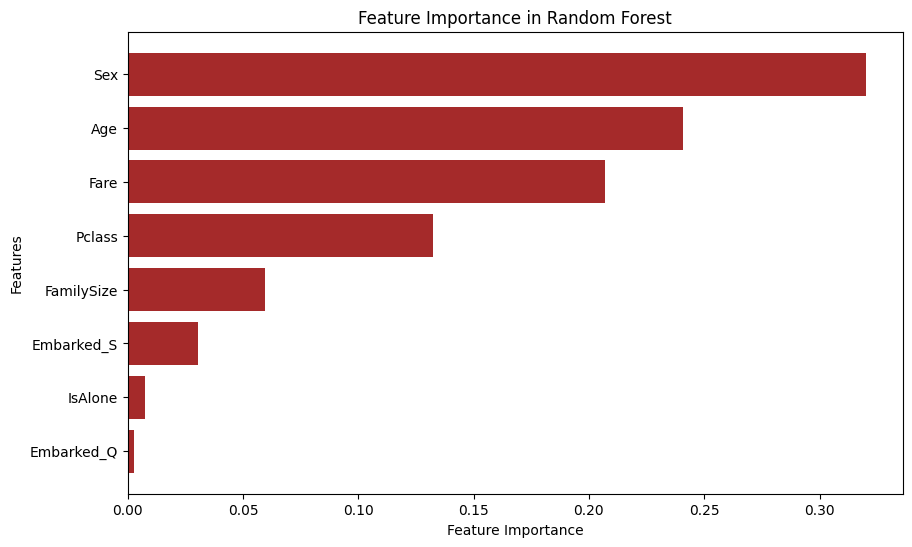

In [38]:
importances = best_rf.feature_importances_

# Sort the feature importances in the descending order of Gini importance
feature_names = X_train_scaled.columns
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Gini Importance': importances}).sort_values('Gini Importance', ascending=False)
print(feature_imp_df)

plt.figure(figsize=(10, 6))
plt.barh(feature_imp_df['Feature'], feature_imp_df['Gini Importance'], color='brown')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance in Random Forest")
plt.gca().invert_yaxis() # descending order
plt.show()

Observation:
- Sex (0.343): Most important by far. The survival rate is highly gender-dependent.
- Age (0.212): Age is crucial, younger passengers had higher chances.
- Fare (0.200): Higher fare likely correlates with higher class and better access to lifeboats.

### XGBoost

In [39]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
evaluate_model(xgb, X_train_scaled, X_test_scaled, Y_train, Y_test)

Train Accuracy: 0.97
Test Accuracy: 0.82

Confusion Matrix (Train):
 [[423   6]
 [ 13 253]]

Confusion Matrix (Test):
 [[90 15]
 [16 53]]

Classification Report (Train):
              precision    recall  f1-score   support

Not Survived       0.97      0.99      0.98       429
    Survived       0.98      0.95      0.96       266

    accuracy                           0.97       695
   macro avg       0.97      0.97      0.97       695
weighted avg       0.97      0.97      0.97       695


Classification Report (Test):
              precision    recall  f1-score   support

Not Survived       0.85      0.86      0.85       105
    Survived       0.78      0.77      0.77        69

    accuracy                           0.82       174
   macro avg       0.81      0.81      0.81       174
weighted avg       0.82      0.82      0.82       174



c:\Users\dbwjd\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:30:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

Overall Performance:
- Accuracy: Yes, the significant gap between the train accuracy (97%) and test accuracy (82%) is a strong indicator of overfitting. This means the model has learned the training data very well, capturing even noise or minor details that don't generalize well to new data (test set).

In [40]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_s = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_s.fit(X_train_scaled, Y_train)

print("Best Parameters:", grid_s.best_params_)
print(f"Best Cross-Validation Score: {grid_s.best_score_:.2f}")

best_xgb = grid_s.best_estimator_
test_accuracy = best_xgb.score(X_test_scaled, Y_test)
print(f"Test Accuracy with Tuned Model: {test_accuracy:.2f}")


Fitting 5 folds for each of 108 candidates, totalling 540 fits


c:\Users\dbwjd\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:30:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 150, 'subsample': 0.8}
Best Cross-Validation Score: 0.83
Test Accuracy with Tuned Model: 0.83


In [41]:
best_xgb = XGBClassifier(
    max_depth=7,
    colsample_bytree=1.0,
    learning_rate=0.01,
    n_estimators=150,
    subsample=0.8,
    random_state=42
)

evaluate_model(best_xgb, X_train_scaled, X_test_scaled, Y_train, Y_test)

Train Accuracy: 0.89
Test Accuracy: 0.83

Confusion Matrix (Train):
 [[414  15]
 [ 61 205]]

Confusion Matrix (Test):
 [[97  8]
 [22 47]]

Classification Report (Train):
              precision    recall  f1-score   support

Not Survived       0.87      0.97      0.92       429
    Survived       0.93      0.77      0.84       266

    accuracy                           0.89       695
   macro avg       0.90      0.87      0.88       695
weighted avg       0.89      0.89      0.89       695


Classification Report (Test):
              precision    recall  f1-score   support

Not Survived       0.82      0.92      0.87       105
    Survived       0.85      0.68      0.76        69

    accuracy                           0.83       174
   macro avg       0.83      0.80      0.81       174
weighted avg       0.83      0.83      0.82       174



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

Overall Performance:
- Accuracy: There's a 6% drop from training to testing accuracy. This drop isn't extreme but still suggests overfitting. However, XGBoost often helps mitigate overfitting better than Random Forest, so tuning could help this further.

- Precision for 'Survived' (0.93) and Recall for 'Survived' (0.77) show that the model is very good at predicting when someone won't survive, but it's missing a significant number of survivors.

      Feature  Gini Importance
1         Sex         0.714299
0      Pclass         0.157140
4  FamilySize         0.042933
2         Age         0.029261
7  Embarked_S         0.023394
3        Fare         0.022614
6  Embarked_Q         0.010359
5     IsAlone         0.000000


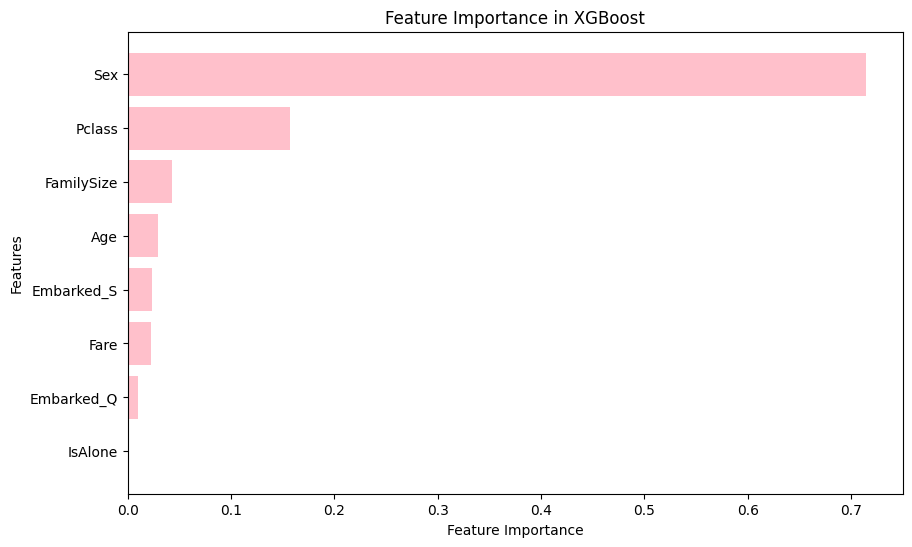

In [42]:
importances = best_xgb.feature_importances_

feature_names = X_train_scaled.columns
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Gini Importance': importances}).sort_values('Gini Importance', ascending=False)
print(feature_imp_df)

plt.figure(figsize=(10, 6))
plt.barh(feature_imp_df['Feature'], feature_imp_df['Gini Importance'], color='pink')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance in XGBoost")
plt.gca().invert_yaxis() # descending order
plt.show()

Observation:
- Sex (0.71): Gender had strong impact on survival. Same as Random Forest result.
- Pclass (0.15): Pclass also has considerable importance, making sense as the class of a passenger (1st, 2nd, or 3rd class) significantly impacted the likelihood of survival.

### SVM

In [43]:
kernels = ['linear', 'poly', 'rbf']
models = {}

for kernel in kernels:
    print(f"Evaluating SVM with kernel: {kernel}")
    svm = SVC(kernel=kernel, probability=True, random_state=42)
    svm.fit(X_train_scaled, Y_train)

    models[f"SVM({kernel})"] = evaluate_model(svm, X_train_scaled, X_test_scaled, Y_train, Y_test)

Evaluating SVM with kernel: linear
Train Accuracy: 0.79
Test Accuracy: 0.84

Confusion Matrix (Train):
 [[376  53]
 [ 94 172]]

Confusion Matrix (Test):
 [[92 13]
 [15 54]]

Classification Report (Train):
              precision    recall  f1-score   support

Not Survived       0.80      0.88      0.84       429
    Survived       0.76      0.65      0.70       266

    accuracy                           0.79       695
   macro avg       0.78      0.76      0.77       695
weighted avg       0.79      0.79      0.78       695


Classification Report (Test):
              precision    recall  f1-score   support

Not Survived       0.86      0.88      0.87       105
    Survived       0.81      0.78      0.79        69

    accuracy                           0.84       174
   macro avg       0.83      0.83      0.83       174
weighted avg       0.84      0.84      0.84       174

Evaluating SVM with kernel: poly
Train Accuracy: 0.82
Test Accuracy: 0.83

Confusion Matrix (Train):
 [[375  5

Overall Performance:
- The test accuracy for all three kernels is quite close, ranging from 0.83 to 0.84. There is no huge difference in terms of generalization to unseen data.

- The RBF kernel and linear kernel seem to perform better in terms of recall for Survived, while the polynomial kernel provides a slightly higher precision for Not Survived.

In [44]:
param_grid_linear = {
    'kernel': ['linear'],
    'C': [0.1, 1, 10, 100]
}

param_grid_rbf = {
    'kernel': ['rbf'],
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001]
}

grid_linear = GridSearchCV(SVC(probability=True, random_state=42), param_grid_linear, cv=5, scoring='accuracy', n_jobs=-1)
grid_linear.fit(X_train_scaled, Y_train)

grid_rbf = GridSearchCV(SVC(probability=True, random_state=42), param_grid_rbf, cv=5, scoring='accuracy', n_jobs=-1)
grid_rbf.fit(X_train_scaled, Y_train)

svm = SVC(probability=True, random_state=42)

best_linear = grid_linear.best_estimator_
best_rbf = grid_rbf.best_estimator_

print("Linear SVM")
print("Best Parameters:", grid_linear.best_params_)
print(f"Train Accuracy: {best_linear.score(X_train_scaled, Y_train):.2f}")
print(f"Test Accuracy: {best_linear.score(X_test_scaled, Y_test):.2f}\n")

print("RBF SVM")
print("Best Parameters:", grid_rbf.best_params_)
print(f"Train Accuracy: {best_rbf.score(X_train_scaled, Y_train):.2f}")
print(f"Test Accuracy: {best_rbf.score(X_test_scaled, Y_test):.2f}")

Linear SVM
Best Parameters: {'C': 1, 'kernel': 'linear'}
Train Accuracy: 0.79
Test Accuracy: 0.84

RBF SVM
Best Parameters: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Train Accuracy: 0.82
Test Accuracy: 0.85


In [45]:
best_rbf = SVC(C=100, gamma=0.01, kernel='rbf', probability=True, random_state=42)

best_rbf.fit(X_train_scaled, Y_train)
evaluate_model(best_rbf, X_train_scaled, X_test_scaled, Y_train, Y_test)

Train Accuracy: 0.82
Test Accuracy: 0.85

Confusion Matrix (Train):
 [[389  40]
 [ 83 183]]

Confusion Matrix (Test):
 [[93 12]
 [14 55]]

Classification Report (Train):
              precision    recall  f1-score   support

Not Survived       0.82      0.91      0.86       429
    Survived       0.82      0.69      0.75       266

    accuracy                           0.82       695
   macro avg       0.82      0.80      0.81       695
weighted avg       0.82      0.82      0.82       695


Classification Report (Test):
              precision    recall  f1-score   support

Not Survived       0.87      0.89      0.88       105
    Survived       0.82      0.80      0.81        69

    accuracy                           0.85       174
   macro avg       0.85      0.84      0.84       174
weighted avg       0.85      0.85      0.85       174



SVC(C=100, gamma=0.01, probability=True, random_state=42)

Observation:

- The test accuracy is higher than the train accuracy, which is a positive sign. This suggests that the model may generalize well on unseen data, indicating that it isn't overfitting (even though the train accuracy is also quite decent).

- The false negatives (FN) and false positives (FP) are a bit higher in the train set compared to the test set. This suggests that the model is doing slightly better in terms of classification on the test data compared to the train data.

### ROC-AUC Curve

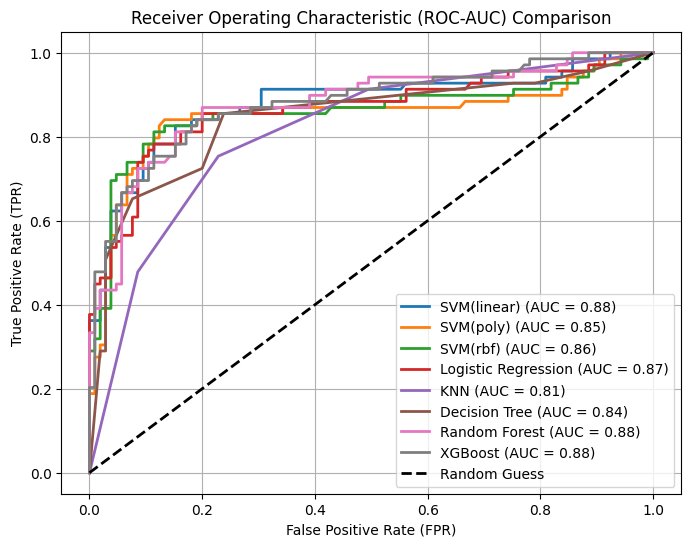

In [46]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(model, X_train_scaled, Y_test, label):

    y_prob = model.predict_proba(X_test_scaled)[:, 1]

    fpr, tpr, _ = roc_curve(Y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2, label = f'{label} (AUC = {roc_auc:.2f})')

plt.figure(figsize=(8,6))

models.update({
    "Logistic Regression": lr,
    "KNN": knn_3,
    "Decision Tree": dt_5,
    "Random Forest": best_rf,
    "XGBoost": best_xgb,
    "SVM(rbf)": best_rbf
})

for label, model in models.items():
    plot_roc_curve(model, X_test_scaled, Y_test, label)

# Random guess line
plt.plot([0,1], [0,1], color='black', lw=2, linestyle='--', label='Random Guess')

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC-AUC) Comparison')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Observation:
- The SVM with Linear kernel, Random Forest, and XGBoost models all have the highest AUC score of 0.88, indicating excellent performance in terms of distinguishing between the positive and negative classes.

- KNN and Decision Tree show lower performance, especially KNN with an AUC of 0.81, indicating it might not be well-suited for this task, possibly due to class imbalance or overfitting.

- The SVM with RBF kernel and SVM with Poly kernel show solid performance but are not as strong as the top models.

### Evaluate on Train Data

In [48]:
joblib.dump(best_rbf, 'SVC_rbf.pkl')
joblib.dump(X_train_scaled.columns.tolist(), 'train_columns.pkl')

['train_columns.pkl']

Conclusion:

- Random Forest: The highest train accuracy of 0.92, with a good test accuracy of 0.84. It shows strong generalization ability. The slight drop from train to test accuracy suggests that it's not overfitting much and performs well on unseen data.

- XGBoost: The train accuracy of 0.89 is lower than Random Forest, and the test accuracy is 0.83. It is also performing well on the test set but not quite as strong as Random Forest.

- SVM with linear kernel: The test accuracy is the same as XGBoost (0.84), but the lower train accuracy (0.79) indicates that the model might be underfitting or struggling to learn from the training data as well as the others. Despite this, it performs reasonably well on the test set.